load full data

In [2]:
import pandas as pd
import numpy as np
taxi_train = pd.read_pickle('data/mimic/train.pkl')
taxi_valid = pd.read_pickle('data/mimic/dev.pkl')
taxi_test = pd.read_pickle('data/mimic/test.pkl')
dim_process = taxi_train['dim_process']
train_taxi = taxi_train['train']
test_taxi = taxi_test['test']
valid_taxi = taxi_valid['dev']
print(len(train_taxi), len(valid_taxi),len(test_taxi), dim_process)

527 58 65 75


In [3]:
lengths = [len(seq) for seq in train_taxi + valid_taxi + test_taxi]  # 计算每个子列表的长度
print(max(lengths), min(lengths), np.mean(lengths))

33 2 3.7215384615384615


In [4]:
train_data = {'time_seqs': [[x["time_since_start"] for x in seq] for seq in train_taxi],
'type_seqs': [[x["type_event"] for x in seq] for seq in train_taxi],
'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in train_taxi]}
valid_data = {'time_seqs': [[x["time_since_start"] for x in seq] for seq in valid_taxi],
'type_seqs': [[x["type_event"] for x in seq] for seq in valid_taxi],
'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in valid_taxi]}
test_data = {'time_seqs': [[x["time_since_start"] for x in seq] for seq in test_taxi],
'type_seqs': [[x["type_event"] for x in seq] for seq in test_taxi],
'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in test_taxi]}
train_data

{'time_seqs': [[0.0, 0.23076923, 0.28846154, 0.34615386],
  [0.0, 0.09615385, 0.1923077, 0.71153843, 1.4807693],
  [0.0, 0.115384616, 2.25, 2.3846154, 3.9423077],
  [0.0, 3.6346154],
  [0.0, 1.4230769, 1.6346154, 1.8846154, 1.9807693],
  [0.0, 0.44230768],
  [0.0, 0.13461539, 1.0384616],
  [0.0, 0.44230768, 2.2115386, 2.4230769, 2.5384614],
  [0.0, 0.115384616, 0.34615386],
  [0.0, 0.46153846, 2.8461537],
  [0.0, 0.115384616, 0.53846157, 0.59615386],
  [0.0, 0.7692308, 1.2307693, 3.0769231],
  [0.0, 0.5, 2.2115386, 2.9615386, 3.0769231],
  [0.0, 0.3653846, 0.42307693, 0.48076922, 0.5],
  [0.0, 2.8461537, 3.0192308, 3.2307692],
  [0.0, 4.5576925, 4.6346154],
  [0.0, 0.115384616, 0.23076923, 0.3653846, 3.6538463, 4.1538463],
  [0.0, 0.40384614, 2.5384614],
  [0.0, 0.03846154, 0.25],
  [0.0, 0.03846154, 0.21153846],
  [0.0, 0.9230769, 0.96153843, 1.4423077],
  [0.0, 0.8269231, 0.9423077, 1.4615384],
  [0.0, 0.115384616, 0.48076922, 0.9807692],
  [0.0, 0.32692307, 1.75],
  [0.0, 2.9230769,

In [5]:
# 初始化一个包含1400个子列表的列表，每个子列表包含10个空列表
train = [[[] for _ in range(dim_process)] for _ in range(len(train_taxi))]
valid = [[[] for _ in range(dim_process)] for _ in range(len(valid_taxi))]
test = [[[] for _ in range(dim_process)] for _ in range(len(test_taxi))]

# 遍历每个列表并提取相应的 time_since_start
for i, sublist in enumerate(train_taxi):
    for event in sublist:
        type_event = event['type_event']
        time_since_start = event['time_since_start']
        if 0 <= type_event <= dim_process-1:
            train[i][type_event].append(time_since_start)

for i, sublist in enumerate(valid_taxi):
    for event in sublist:
        type_event = event['type_event']
        time_since_start = event['time_since_start']
        if 0 <= type_event <= dim_process-1:
            valid[i][type_event].append(time_since_start)

for i, sublist in enumerate(test_taxi):
    for event in sublist:
        type_event = event['type_event']
        time_since_start = event['time_since_start']
        if 0 <= type_event <= dim_process-1:
            test[i][type_event].append(time_since_start)

# 将每个子列表转换为 numpy 数组
train = [[np.array(times, dtype=np.float64) for times in sublist] for sublist in train]
valid = [[np.array(times, dtype=np.float64) for times in sublist] for sublist in valid]
test = [[np.array(times, dtype=np.float64) for times in sublist] for sublist in test]

print(train, test)

[[array([], dtype=float64), array([0.        , 0.23076923, 0.28846154, 0.34615386]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array

fit hawkes process

In [6]:
import matplotlib.pyplot as plt
from tick.hawkes import HawkesSumExpKern,HawkesExpKern, HawkesConditionalLaw
from tick.hawkes import SimuHawkesExpKernels  # NOQA
from tick.plot import plot_point_process, plot_hawkes_kernel_norms
from tick.dataset import fetch_hawkes_bund_data

np.random.seed(42)

# fit
# 所有维度的基准强度相同
# baseline = np.full(dim_process, 0.2)  # dim_process 个维度，基准强度都是 0.2

# 2. 创建衰减矩阵，单位矩阵加上少量噪声
decay_matrix = np.eye(dim_process) + 0.01 * np.random.randn(dim_process, dim_process)
kwargs = {}
# if Fitter == HawkesExpKern:
#     if 'penalty' not in kwargs:
#         kwargs['penalty'] = 'elasticnet'
#         kwargs['elastic_net_ratio'] = 0.8
learner = HawkesExpKern(decays=decay_matrix, max_iter=500, **kwargs)
learner.fit(train)

In [31]:
print(learner.baseline, learner.decays, learner.adjacency)
import torch
torch.save({
    'baseline': learner.baseline,
    'decays': learner.decays,
    'adjacency': learner.adjacency
}, 'residual_data/mimic/hawkes_params.pth')

[3.32628636e-01 2.00933912e-01 9.30369443e-03 3.06731483e-03
 2.06139296e-03 1.35893974e-05 1.57656903e-02 3.10359005e-02
 8.40486974e-02 2.58747929e-03 4.05544867e-02 8.83596428e-02
 3.98576516e-03 2.33393374e-02 1.80174613e-02 1.62388365e-02
 5.07438338e-03 5.47536527e-03 8.39130756e-03 1.01375103e-02
 1.14512967e-02 4.81936458e-03 4.91515280e-03 1.08563213e-03
 3.19083521e-03 2.03967098e-02 1.54806444e-02 1.09748914e-02
 2.15759477e-03 1.13200755e-03 2.12829993e-03 2.45823342e-03
 1.26710654e-02 4.06628526e-03 4.59330854e-03 2.09173639e-03
 1.96091320e-03 5.89011597e-03 2.05861227e-03 2.13443061e-03
 1.20670014e-03 4.06465160e-03 5.43833767e-03 2.19923067e-03
 5.06338463e-03 5.12454996e-03 1.13308924e-02 2.06138350e-03
 2.27034013e-03 1.82327163e-03 2.64948444e-03 9.47128613e-04
 4.27869108e-03 0.00000000e+00 2.11709493e-03 3.40861664e-03
 4.85363778e-05 2.87129068e-03 2.34365623e-03 6.00297700e-06
 3.48928850e-05 9.11024083e-06 1.07188948e-03 4.63040067e-03
 2.00323520e-03 2.236039

In [8]:
print(learner.score(events=train,baseline=learner.baseline, adjacency=learner.adjacency),
      learner.score(events=valid,baseline=learner.baseline, adjacency=learner.adjacency),
      learner.score(events=test,baseline=learner.baseline, adjacency=learner.adjacency))

1.1262984964806624 1.9896176665678829 1.0641611399467528


compute w & compare to threshold

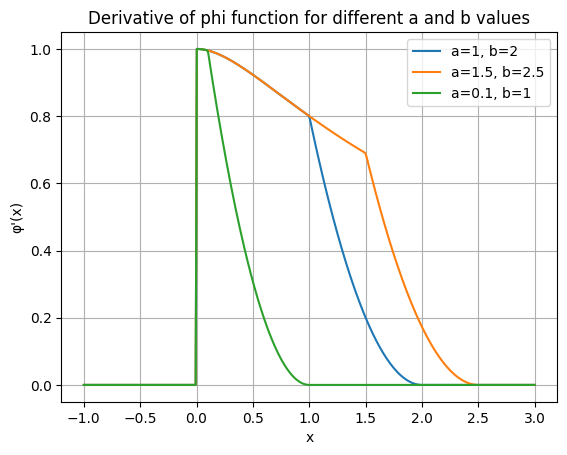

In [9]:
def phi_derivative(x, a, b):
    """
    计算 φ'(x) 的值。
    """
    if 0 <= x <= a:
        return (1 + x) / (1 + x + x**2 / 2)
    elif a < x <= b:
        return phi_derivative(a, a, b) * ((b - x) ** 2) / ((b - a) ** 2)
    else:
        return 0

# 定义x的范围
x_vals = np.linspace(-1, 3, 400)

# 绘制多个不同a和b值对应的phi_derivative曲线

for a, b in [(1, 2), (1.5, 2.5), (0.1, 1)]:
    y_vals = np.array([phi_derivative(x, a, b) for x in x_vals])
    plt.plot(x_vals, y_vals, label=f'a={a}, b={b}')

# 添加标题和标签
plt.title("Derivative of phi function for different a and b values")
plt.xlabel("x")
plt.ylabel("φ'(x)")
plt.legend()
plt.grid(True)
plt.show()

d:\Anaconda\envs\easytpp\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


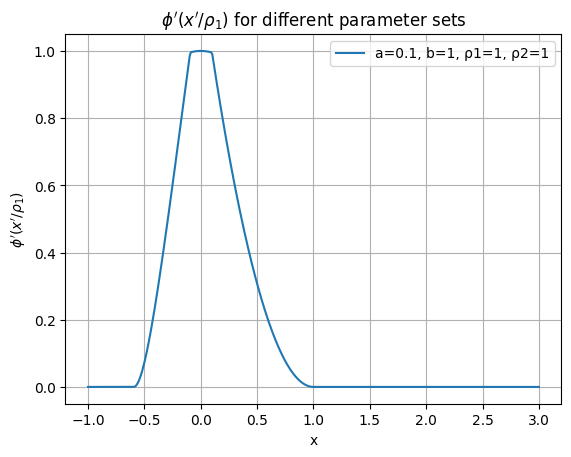

In [10]:
from scipy.optimize import fsolve

def phi_prime(x, a, b, rho1, rho2):
    if x >= 0:
        return phi_derivative(x / rho2, a, b)
    
    elif -1 <= x < 0:
        # 定义方程 (x' + 1) exp(-x' - 1) = (x + 1) exp(-x - 1)
        def equation(x_prime):
            return (x_prime + 1) * np.exp(-x_prime - 1) - (x + 1) * np.exp(-x - 1)

        # 求解方程得到x'
        x_prime = fsolve(equation, 0.5)[0]  # 初始猜测值设为0

        # 计算 φ'(x′ / ρ1)
        return phi_derivative(x_prime / rho1, a, b)
    else:
        raise ValueError("x must be in the range [-1, infinity)")

for a, b, rho1, rho2 in [(0.1, 1, 1, 1)]:
    y_vals = np.array([phi_prime(x, a, b, rho1, rho2) for x in x_vals])
    plt.plot(x_vals, y_vals, label=f'a={a}, b={b}, ρ1={rho1}, ρ2={rho2}')

# 添加标题和标签
plt.title(r"$\phi'(x' / \rho_1)$ for different parameter sets")
plt.xlabel("x")
plt.ylabel(r"$\phi'(x' / \rho_1)$")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from numba import jit

@jit(nopython=True)
def lambda_k(u, baseline, adjacency_vector, decay_vector, event_times):
    """Hawkes强度函数"""
    # 基线强度
    mu_k = baseline
    intensity = mu_k    
    # 事件历史的影响
    for j in range(len(event_times)):  # 假设事件times是二维数组，每个事件类型对应一个时间数组
        for t_j in event_times[j]:
            if t_j <= u:  # 确保时间t_j早于u
                alpha_kj = adjacency_vector[j]  # adjacency_vector存储了影响系数
                beta_kj = decay_vector[j]  # decay_vector存储了衰减系数
                intensity += alpha_kj * np.exp(-beta_kj * (u - t_j))    
    return intensity

In [12]:
from scipy.integrate import quad
from joblib import Parallel, delayed

def compute_w(baseline, t_points, rho1, rho2, a, b, adjacency_matrix, decay_matrix, event_times):
    w_values = np.zeros(len(t_points) - 1)  # 预分配内存，避免重复分配

    def calculate_w_i(t_start, t_end):
        max_w_k = -np.inf  # 直接使用最大值计算，避免创建列表
        for k in range(len(baseline)):  # 遍历每个B_k
            integral_value, _ = quad(
                lambda u: lambda_k(u, baseline[k], adjacency_matrix[k], decay_matrix[k], event_times),
                t_start, t_end
            )
            w_i = phi_prime(integral_value - 1, rho1, rho2, a, b)
            max_w_k = max(max_w_k, w_i)  # 找到最大值
        return max_w_k

    # 并行计算每个时间段的 w_i(S; B) 
    w_values = Parallel(n_jobs=-1)(delayed(calculate_w_i)(t_points[i-1], t_points[i]) for i in range(1, len(t_points)))
    
    return np.array(w_values)

a, b, rho1, rho2  = (0.1, 1, 1, 1)
# w = compute_w(learner.baseline, train_data['time_seqs'][0], rho1, rho2, a, b, learner.adjacency, learner.decays, train[0])

In [13]:
train_weight = []
for i in range(len(train_data['time_seqs'])):
    w = compute_w(learner.baseline, train_data['time_seqs'][i], rho1, rho2, a, b, learner.adjacency, learner.decays, train[i])
    train_weight.append(w)

In [14]:
train_weight

[array([0, 0, 0]),
 array([0.        , 0.        , 0.98815319, 0.87164822]),
 array([0.        , 0.86164985, 0.        , 0.81041233]),
 array([0.9999873]),
 array([0.9426414, 0.       , 0.       , 0.       ]),
 array([0]),
 array([0, 0]),
 array([0.        , 0.99197187, 0.        , 0.        ]),
 array([0, 0]),
 array([0.        , 0.99911645]),
 array([0.        , 0.92201341, 0.        ]),
 array([0.84417402, 0.        , 0.99900653]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0]),
 array([0.92234669, 0.        ]),
 array([0.        , 0.        , 0.        , 0.96549018, 0.        ]),
 array([0.        , 0.96226402]),
 array([0, 0]),
 array([0, 0]),
 array([0.99989273, 0.        , 0.        ]),
 array([0.        , 0.        , 0.98102494]),
 array([0.        , 0.        , 0.99865902]),
 array([0.        , 0.99957337]),
 array([0, 0]),
 array([0, 0, 0]),
 array([0.        , 0.88383982, 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.99452013]),
 arra

In [15]:
test_weight = []
for i in range(len(test_data['time_seqs'])):
    w = compute_w(learner.baseline, test_data['time_seqs'][i], rho1, rho2, a, b, learner.adjacency, learner.decays, test[i])
    test_weight.append(w)
valid_weight = []
for i in range(len(valid_data['time_seqs'])):
    w = compute_w(learner.baseline, valid_data['time_seqs'][i], rho1, rho2, a, b, learner.adjacency, learner.decays, valid[i])
    valid_weight.append(w)

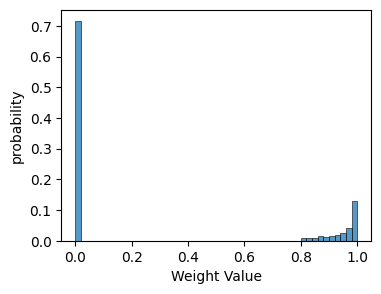

In [19]:
import seaborn as sns
merged_train = np.concatenate(train_weight)
merged_test = np.concatenate(test_weight)
merged_valid = np.concatenate(valid_weight)
merged_data = np.concatenate([merged_train, merged_test, merged_valid])

plt.figure(figsize=(4, 3))
sns.histplot(merged_data, bins=50, stat="probability")

# 显示图形
# plt.title("Distribution of Weight Values on Testing Data")
plt.xlabel("Weight Value")
plt.ylabel("probability")
plt.savefig('figures/mimic.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [20]:
print(len(merged_train[merged_train==0])/len(merged_train), len(merged_test[merged_test==0])/len(merged_test), len(merged_valid[merged_valid==0])/len(merged_valid))
print((len(merged_train[merged_train==0])+len(merged_test[merged_test==0])+len(merged_valid[merged_valid==0]))/(len(merged_train)+len(merged_test)+len(merged_valid)))
res_weight = round((len(merged_train[merged_train==0])+len(merged_test[merged_test==0])+len(merged_valid[merged_valid==0]))/(len(merged_train)+len(merged_test)+len(merged_valid)), 2)
print(res_weight)

0.7213114754098361 0.7267441860465116 0.6752577319587629
0.7167891464104014
0.72


In [21]:
import pickle
# 存储每个数组中小于0.8的元素的索引，同时保留第一个元素
train_res_indices = []
valid_res_indices = []
test_res_indices = []

def get_indices(weights):
    indices = []
    for w in weights:
        # 保留第一个和最后一个元素的索引
        first_idx = [0]
        last_idx = [len(w) - 1]
        # 获取中间部分小于0.8的索引
        other_indices = np.where(w[1:-1] < 0.5)[0] + 1  # +1 是因为我们跳过第一个元素
        # 合并第一个、最后一个索引以及中间小于0.8的索引
        indices.append(np.concatenate((first_idx, other_indices, last_idx)))
    return indices

train_res_indices = get_indices(train_weight)
valid_res_indices = get_indices(valid_weight)
test_res_indices = get_indices(test_weight)

def process_dataset(data, indices):
    processed_data = {
        'time_seqs': [],
        'type_seqs': [],
        'time_delta_seqs': []
    }
    
    for i, idx in enumerate(indices):
        time_seqs = [data['time_seqs'][i][j] for j in idx]
        type_seqs = [data['type_seqs'][i][j] for j in idx]
        time_delta_seqs = [data['time_delta_seqs'][i][j] for j in idx]
        
        processed_data['time_seqs'].append(time_seqs)
        processed_data['type_seqs'].append(type_seqs)
        processed_data['time_delta_seqs'].append(time_delta_seqs)
    
    return processed_data

train_residual = process_dataset(train_data, train_res_indices)
valid_residual = process_dataset(valid_data, valid_res_indices)
test_residual = process_dataset(test_data, test_res_indices)

In [22]:
lengths = [len(arr) for arr in valid_res_indices]
min_length = min(lengths)
max_length = max(lengths)
print(f"Minimum length: {min_length}")
print(f"Maximum length: {max_length}")

Minimum length: 2
Maximum length: 24


In [23]:
def convert_data(data):
    data_list = []
    for i in range(len(data['time_seqs'])):
        events = []
        for j in range(len(data['time_seqs'][i])):
            event = {
                'idx_event': j + 1,
                'type_event': data['type_seqs'][i][j],
                'time_since_start': data['time_seqs'][i][j],
                'time_since_last_event': data['time_delta_seqs'][i][j]
            }
            events.append(event)
        data_list.append(events)
    return data_list

# 调用函数转换每个数据集
train_data_list = convert_data(train_residual)
valid_data_list = convert_data(valid_residual)
test_data_list = convert_data(test_residual)

In [24]:
train_data_dict = {}
valid_data_dict = {}
test_data_dict = {}
train_data_dict['dim_process'] = dim_process
train_data_dict['train'] = train_data_list
valid_data_dict['dim_process'] = dim_process
valid_data_dict['dev'] = valid_data_list
test_data_dict['dim_process'] = dim_process
test_data_dict['test'] = test_data_list
valid_data_dict

{'dim_process': 75,
 'dev': [[{'idx_event': 1,
    'type_event': 0,
    'time_since_start': 0.0,
    'time_since_last_event': 0.0},
   {'idx_event': 2,
    'type_event': 0,
    'time_since_start': 0.03846154,
    'time_since_last_event': 0.03846154}],
  [{'idx_event': 1,
    'type_event': 0,
    'time_since_start': 0.0,
    'time_since_last_event': 0.0},
   {'idx_event': 2,
    'type_event': 0,
    'time_since_start': 0.09615385,
    'time_since_last_event': 0.09615385},
   {'idx_event': 3,
    'type_event': 0,
    'time_since_start': 0.13461539,
    'time_since_last_event': 0.038461544},
   {'idx_event': 4,
    'type_event': 0,
    'time_since_start': 0.23076923,
    'time_since_last_event': 0.09615384},
   {'idx_event': 5,
    'type_event': 0,
    'time_since_start': 0.3653846,
    'time_since_last_event': 0.13461538},
   {'idx_event': 6,
    'type_event': 0,
    'time_since_start': 0.44230768,
    'time_since_last_event': 0.07692307},
   {'idx_event': 7,
    'type_event': 0,
    'ti

In [25]:
import os
os.makedirs('residual_data/mimic', exist_ok=True)

with open('residual_data/mimic/train.pkl', 'wb') as f:
    pickle.dump(train_data_dict, f)
with open('residual_data/mimic/dev.pkl', 'wb') as f:
    pickle.dump(valid_data_dict, f)
with open('residual_data/mimic/test.pkl', 'wb') as f:
    pickle.dump(test_data_dict, f)

In [26]:
with open('residual_data/mimic/train.pkl', 'rb') as f:
    train_res_dict = pickle.load(f)
with open('residual_data/mimic/dev.pkl', 'rb') as f:
    valid_res_dict = pickle.load(f)
with open('residual_data/mimic/test.pkl', 'rb') as f:
    test_res_dict = pickle.load(f)
valid_res_dict

{'dim_process': 75,
 'dev': [[{'idx_event': 1,
    'type_event': 0,
    'time_since_start': 0.0,
    'time_since_last_event': 0.0},
   {'idx_event': 2,
    'type_event': 0,
    'time_since_start': 0.03846154,
    'time_since_last_event': 0.03846154}],
  [{'idx_event': 1,
    'type_event': 0,
    'time_since_start': 0.0,
    'time_since_last_event': 0.0},
   {'idx_event': 2,
    'type_event': 0,
    'time_since_start': 0.09615385,
    'time_since_last_event': 0.09615385},
   {'idx_event': 3,
    'type_event': 0,
    'time_since_start': 0.13461539,
    'time_since_last_event': 0.038461544},
   {'idx_event': 4,
    'type_event': 0,
    'time_since_start': 0.23076923,
    'time_since_last_event': 0.09615384},
   {'idx_event': 5,
    'type_event': 0,
    'time_since_start': 0.3653846,
    'time_since_last_event': 0.13461538},
   {'idx_event': 6,
    'type_event': 0,
    'time_since_start': 0.44230768,
    'time_since_last_event': 0.07692307},
   {'idx_event': 7,
    'type_event': 0,
    'ti

In [27]:
train_res = {'time_seqs': [[x["time_since_start"] for x in seq] for seq in train_res_dict['train']],
'type_seqs': [[x["type_event"] for x in seq] for seq in train_res_dict['train']],
'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in train_res_dict['train']]}
valid_res = {'time_seqs': [[x["time_since_start"] for x in seq] for seq in valid_res_dict['dev']],
'type_seqs': [[x["type_event"] for x in seq] for seq in valid_res_dict['dev']],
'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in valid_res_dict['dev']]}
test_res = {'time_seqs': [[x["time_since_start"] for x in seq] for seq in test_res_dict['test']],
'type_seqs': [[x["type_event"] for x in seq] for seq in test_res_dict['test']],
'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in test_res_dict['test']]}
train_res

{'time_seqs': [[0.0, 0.23076923, 0.28846154],
  [0.0, 0.09615385, 0.71153843],
  [0.0, 2.25, 2.3846154],
  [0.0, 0.0],
  [0.0, 1.4230769, 1.6346154, 1.8846154],
  [0.0, 0.0],
  [0.0, 0.13461539],
  [0.0, 2.2115386, 2.4230769],
  [0.0, 0.115384616],
  [0.0, 0.46153846],
  [0.0, 0.53846157],
  [0.0, 0.7692308, 1.2307693],
  [0.0, 0.5, 2.2115386, 2.9615386],
  [0.0, 0.3653846, 0.42307693, 0.48076922],
  [0.0, 2.8461537, 3.0192308],
  [0.0, 4.5576925],
  [0.0, 0.115384616, 0.23076923, 3.6538463],
  [0.0, 0.40384614],
  [0.0, 0.03846154],
  [0.0, 0.03846154],
  [0.0, 0.9230769, 0.96153843],
  [0.0, 0.8269231, 0.9423077],
  [0.0, 0.115384616, 0.48076922],
  [0.0, 0.32692307],
  [0.0, 2.9230769],
  [0.0, 0.115384616, 0.25],
  [0.0, 0.5769231],
  [0.0, 0.65384614, 0.75, 0.96153843, 1.1346154],
  [0.0, 1.2692307, 1.3653846],
  [0.0, 0.0],
  [0.0, 0.057692308],
  [0.0, 0.0],
  [0.0, 4.980769],
  [0.0, 2.6923077],
  [0.0, 0.44230768],
  [0.0, 0.8269231, 1.6923077],
  [0.0, 0.28846154],
  [0.0, 1.

### test set上计算hawkes process 的intensity

In [51]:
import torch
from torch import nn
from torch.nn import functional as F

max_length = max(max(len(seq) for seq in train_data['time_delta_seqs']), max(len(seq) for seq in valid_data['time_delta_seqs']), max(len(seq) for seq in test_data['time_delta_seqs']))
print(max_length)

# 初始化填充后的数组和掩码数组
time_seq = np.full((len(test_data['time_seqs']), max_length), 75, dtype=float)
time_delta_seq = np.full((len(test_data['time_delta_seqs']), max_length), 75, dtype=float)
type_seq = np.full((len(test_data['time_delta_seqs']), max_length), 75)
seq_mask = np.zeros((len(test_data['time_delta_seqs']), max_length), dtype=bool)

# 填充数据和生成掩码
for i, (time_seq_i, time_delta_seq_i, type_seq_i) in enumerate(zip(test_data['time_seqs'], test_data['time_delta_seqs'], test_data['type_seqs'])):
    time_seq[i, :len(time_seq_i)] = time_seq_i  # 填充时间序列
    time_delta_seq[i, :len(time_delta_seq_i)] = time_delta_seq_i
    type_seq[i, :len(type_seq_i)] = type_seq_i  # 填充类型序列
    seq_mask[i, :len(time_seq_i)] = 1  # 更新掩码，非填充部分为True

time_seq = torch.tensor(time_seq, dtype=torch.float32)
time_delta_seq = torch.tensor(time_delta_seq, dtype=torch.float32)
type_seq = torch.tensor(type_seq, dtype=torch.long)
seq_mask = torch.tensor(seq_mask, dtype=torch.bool)

# 打印结果
print("Padded Data:\n", time_seq, time_seq.shape, time_delta_seq, time_delta_seq.shape)
print("Type Sequence Tensor:\n", type_seq, type_seq.shape)
print("Sequence Mask:\n", seq_mask)

33
Padded Data:
 tensor([[0.0000e+00, 2.5000e-01, 5.3846e-01,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        [0.0000e+00, 4.8077e-01, 5.7692e-01,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        [0.0000e+00, 1.9231e-02, 2.3077e-01,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        ...,
        [0.0000e+00, 1.5962e+00, 2.7885e+00,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        [0.0000e+00, 3.4615e-01, 1.0192e+00,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        [0.0000e+00, 3.8462e-02, 2.1154e-01,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01]]) torch.Size([65, 33]) tensor([[0.0000e+00, 2.5000e-01, 2.8846e-01,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        [0.0000e+00, 4.8077e-01, 9.6154e-02,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        [0.0000e+00, 1.9231e-02, 2.1154e-01,  ..., 7.5000e+01, 7.5000e+01,
         7.5000e+01],
        ...,
        [0.0000e+00, 1.5962e+00, 1.1923e+00,  ..., 7.5000e+01,

In [52]:
batch_size = len(test)
num_event_types = len(test[0])  # Assuming each sample has the same number of event types

# Convert test to a tensor of shape (batch_size, num_event_types, max_event_count)
max_event_count = max(len(test[i][k]) for i in range(batch_size) for k in range(num_event_types))
test_tensor = torch.full((batch_size, num_event_types, max_event_count), num_event_types)

for i in range(batch_size):
    for k in range(num_event_types):
        # Convert each event time sequence to tensor and store in test_tensor
        test_tensor[i, k, :len(test[i][k])] = torch.tensor(test[i][k])

In [34]:
test_tensor.shape

torch.Size([65, 75, 7])

In [50]:
# 保存张量
print(time_seq.shape, time_delta_seq.shape, type_seq.shape, seq_mask.shape)
torch.save({
    'time_seq': time_seq,
    'time_delta_seq': time_delta_seq,
    'type_seq': type_seq,
    'seq_mask': seq_mask,
    'test_tensor': test_tensor
}, 'residual_data/mimic/tensors.pth')

torch.Size([65, 33]) torch.Size([65, 33]) torch.Size([65, 33]) torch.Size([65, 33])


event intensities

In [53]:
import torch

def lambda_k(u, baseline, adjacency_vector, decay_vector, event_times):
    mu_k = baseline
    intensity = mu_k
    
    # 事件历史的影响
    # 通过利用已排序的事件时间，减少计算
    for j in range(len(event_times)):  # 假设event_times是二维数组
        # 用二分查找寻找最接近的时间点（优化历史时间的查找）
        valid_event_times = event_times[j][event_times[j] <= u]
        if len(valid_event_times) > 0:
            alpha_kj = adjacency_vector[j]  # adjacency_vector存储了影响系数
            beta_kj = decay_vector[j]  # decay_vector存储了衰减系数
            time_deltas = u - valid_event_times
            intensity += torch.sum(alpha_kj * torch.exp(-beta_kj * time_deltas))
    
    return intensity

def compute_hawkes_intensities(time_seqs, baseline, adjacency_matrix, decay_matrix, event_times):
    batch_size, seq_len = time_seqs.shape
    num_event_types = len(baseline)
    
    intensities = torch.zeros((batch_size, seq_len, num_event_types))
    
    for i in range(batch_size):
        for j in range(seq_len):
            u = time_seqs[i, j].item()
            for k in range(num_event_types):
                intensities[i, j, k] = lambda_k(u, baseline[k], adjacency_matrix[k], decay_matrix[k], event_times[i])
    return intensities

# 计算强度
event_intensities = compute_hawkes_intensities(time_seq[:, :-1], learner.baseline, learner.adjacency, learner.decays, test_tensor)
print(event_intensities.shape, event_intensities)

torch.Size([65, 32, 75]) tensor([[[9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
          2.6766e-02, 2.5610e-02],
         [9.4935e-01, 2.4883e+00, 2.1858e-02,  ..., 3.3172e-02,
          2.6790e-02, 2.5576e-02],
         [9.5130e-01, 1.9209e+00, 2.1888e-02,  ..., 3.3179e-02,
          2.6817e-02, 2.5538e-02],
         ...,
         [2.5145e+01, 1.3391e+01, 1.2510e+01,  ..., 5.0613e+00,
          4.6532e+00, 4.6481e+00],
         [2.5145e+01, 1.3391e+01, 1.2510e+01,  ..., 5.0613e+00,
          4.6532e+00, 4.6481e+00],
         [2.5145e+01, 1.3391e+01, 1.2510e+01,  ..., 5.0613e+00,
          4.6532e+00, 4.6481e+00]],

        [[3.5966e-01, 2.2796e-01, 3.6331e-02,  ..., 2.9280e-02,
          2.7035e-02, 2.7033e-02],
         [3.6000e-01, 2.2792e-01, 3.6392e-02,  ..., 2.9302e-02,
          2.6863e-02, 1.6579e-02],
         [3.6007e-01, 2.2791e-01, 3.6405e-02,  ..., 2.9306e-02,
          2.6829e-02, 1.5035e-02],
         ...,
         [2.4212e+01, 1.7733e+01, 1.2511e+01,  ..., 5.

In [54]:
def lambda_k(u, baseline, adjacency_vector, decay_vector, event_times):
    mu_k = baseline
    intensity = mu_k    
    # 事件历史的影响
    for j in range(len(event_times)):  # 假设事件times是二维数组，每个事件类型对应一个时间数组
        for t_j in event_times[j]:
            if t_j <= u:  # 确保时间t_j早于u
                alpha_kj = adjacency_vector[j]  # adjacency_vector存储了影响系数
                beta_kj = decay_vector[j]  # decay_vector存储了衰减系数
                intensity += alpha_kj * torch.exp(-beta_kj * (u - t_j))    
    return intensity

def compute_hawkes_intensities(time_seqs, baseline, adjacency_matrix, decay_matrix, event_times):
    batch_size, seq_len = time_seqs.shape
    num_event_types = len(baseline)
    
    intensities = torch.zeros((batch_size, seq_len, num_event_types))
    
    for i in range(batch_size):
        for j in range(seq_len):
            u = time_seqs[i, j].item()
            for k in range(num_event_types):
                intensities[i, j, k] = lambda_k(u, baseline[k], adjacency_matrix[k], decay_matrix[k], event_times[i])
    return intensities

# 计算强度
event_intensities = compute_hawkes_intensities(time_seq[:,:-1], learner.baseline, learner.adjacency, learner.decays, test_tensor)
print(event_intensities.shape, event_intensities)  # 应该输出 torch.Size([400, 37, 10])

torch.Size([65, 32, 75]) tensor([[[9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
          2.6766e-02, 2.5610e-02],
         [9.4935e-01, 2.4883e+00, 2.1858e-02,  ..., 3.3172e-02,
          2.6790e-02, 2.5576e-02],
         [9.5130e-01, 1.9209e+00, 2.1888e-02,  ..., 3.3179e-02,
          2.6817e-02, 2.5538e-02],
         ...,
         [2.5145e+01, 1.3391e+01, 1.2510e+01,  ..., 5.0613e+00,
          4.6532e+00, 4.6481e+00],
         [2.5145e+01, 1.3391e+01, 1.2510e+01,  ..., 5.0613e+00,
          4.6532e+00, 4.6481e+00],
         [2.5145e+01, 1.3391e+01, 1.2510e+01,  ..., 5.0613e+00,
          4.6532e+00, 4.6481e+00]],

        [[3.5966e-01, 2.2796e-01, 3.6331e-02,  ..., 2.9280e-02,
          2.7035e-02, 2.7033e-02],
         [3.6000e-01, 2.2792e-01, 3.6392e-02,  ..., 2.9302e-02,
          2.6863e-02, 1.6579e-02],
         [3.6007e-01, 2.2791e-01, 3.6405e-02,  ..., 2.9306e-02,
          2.6829e-02, 1.5035e-02],
         ...,
         [2.4212e+01, 1.7733e+01, 1.2511e+01,  ..., 5.

sample intensities

In [56]:
def make_dtime_loss_samples(time_delta_seq, steps):
    """Generate the time point samples for every interval.
    Args:
        time_delta_seq (tensor): [batch_size, seq_len].
    Returns:
        tensor: [batch_size, seq_len, n_samples]
    """
    # [1, 1, n_samples]
    dtimes_ratio_sampled = torch.linspace(start=0.0,
                                            end=1.0,
                                            steps=steps)[None, None, :]
    # [batch_size, max_len, n_samples]
    sampled_dtimes = time_delta_seq[:, :, None] * dtimes_ratio_sampled
    return sampled_dtimes

sample_time_delta_seq = make_dtime_loss_samples(time_delta_seq[:, 1:], steps=20)

def compute_sampled_intensities(sample_time_delta_seq, baseline, adjacency_matrix, decay_matrix, event_times):
    batch_size, seq_len, num_samples = sample_time_delta_seq.shape
    num_event_types = len(baseline)
    
    intensities = torch.zeros((batch_size, seq_len, num_samples, num_event_types), dtype=torch.float32)
    
    for i in range(batch_size):
        for j in range(seq_len):
            for s in range(num_samples):
                u = sample_time_delta_seq[i, j, s].item()
                for k in range(num_event_types):
                    intensities[i, j, s, k] = lambda_k(u, baseline[k], adjacency_matrix[k], decay_matrix[k], event_times[i])    
    return intensities

sampled_intensities = compute_sampled_intensities(sample_time_delta_seq, learner.baseline, learner.adjacency, learner.decays, test_tensor)
print(sampled_intensities.shape, sampled_intensities)

torch.Size([65, 32, 20, 75]) tensor([[[[9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4777e-01, 3.0936e+00, 2.1834e-02,  ..., 3.3166e-02,
           2.6767e-02, 2.5608e-02],
          [9.4785e-01, 3.0561e+00, 2.1835e-02,  ..., 3.3167e-02,
           2.6768e-02, 2.5606e-02],
          ...,
          [9.4918e-01, 2.5487e+00, 2.1856e-02,  ..., 3.3171e-02,
           2.6787e-02, 2.5580e-02],
          [9.4927e-01, 2.5183e+00, 2.1857e-02,  ..., 3.3172e-02,
           2.6788e-02, 2.5578e-02],
          [9.4935e-01, 2.4883e+00, 2.1858e-02,  ..., 3.3172e-02,
           2.6790e-02, 2.5576e-02]],

         [[9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4778e-01, 3.0878e+00, 2.1834e-02,  ..., 3.3166e-02,
           2.6767e-02, 2.5608e-02],
          [9.4788e-01, 3.0446e+00, 2.1836e-02,  ..., 3.3167e-02,
           2.6769e-02, 2.5606e-02],
          ...,
          [9.4941e-01, 2.4701e

In [58]:
dtime_for_bound_sampled = make_dtime_loss_samples(time_delta_seq[:, :-1], steps=5)
bound_sampled_intensities = compute_sampled_intensities(dtime_for_bound_sampled, learner.baseline, learner.adjacency, learner.decays, test_tensor)
print(bound_sampled_intensities.shape, bound_sampled_intensities)

torch.Size([65, 32, 5, 75]) tensor([[[[9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02]],

         [[9.4768e-01, 3.1316e+00, 2.1833e-02,  ..., 3.3166e-02,
           2.6766e-02, 2.5610e-02],
          [9.4810e-01, 2.9554e+00, 2.1839e-02,  ..., 3.3167e-02,
           2.6772e-02, 2.5601e-02],
          [9.4852e-01, 2.7899e+00, 2.1845e-02,  ..., 3.3169e-02,
           2.6778e-02, 2.5593e-02],
          [9.4893e-01, 2.6344e+00, 2.1852e-02,  ..., 3.3171e-02,
           2.6784e-02, 2.5585e-02],
          [9.4935e-01, 2.4883e+00, 2.1858e-02,  ..., 3.3172e-

In [68]:
# 保存张量
print(time_seq.shape, time_delta_seq.shape, type_seq.shape, seq_mask.shape, sample_time_delta_seq.shape)
torch.save({
    'time_seq': time_seq,
    'time_delta_seq': time_delta_seq,
    'type_seq': type_seq,
    'seq_mask': seq_mask,
    'sample_time_delta_seq': sample_time_delta_seq,
    'dtime_for_bound_sampled': dtime_for_bound_sampled,
    'bound_sampled_intensities': bound_sampled_intensities,
    'event_intensities': event_intensities,
    'test_tensor': test_tensor
}, 'residual_data/mimic/tensors.pth')

torch.Size([65, 33]) torch.Size([65, 33]) torch.Size([65, 33]) torch.Size([65, 33]) torch.Size([65, 32, 20])


## Evaluation

hawkes

In [61]:
eps = torch.finfo(torch.float32).eps
pad_token_id = dim_process

def compute_loglikelihood(time_delta_seq, lambda_at_event, lambdas_loss_samples, seq_mask, type_seq):
    """Compute the loglikelihood of the event sequence based on Equation (8) of NHP paper.

    Args:
        time_delta_seq (tensor): [batch_size, seq_len], time_delta_seq from model input.
        lambda_at_event (tensor): [batch_size, seq_len, num_event_types], unmasked intensity at
        (right after) the event.
        lambdas_loss_samples (tensor): [batch_size, seq_len, num_sample, num_event_types],
        intensity at sampling times.
        seq_mask (tensor): [batch_size, seq_len], sequence mask vector to mask the padded events.
        type_seq (tensor): [batch_size, seq_len], sequence of mark ids, with padded events having a mark of self.pad_token_id

    Returns:
        tuple: event loglike, non-event loglike, intensity at event with padding events masked
    """
    # First, add an epsilon to every marked intensity for stability
    lambda_at_event = lambda_at_event + eps
    lambdas_loss_samples = lambdas_loss_samples + eps

    log_marked_event_lambdas = lambda_at_event.log()
    total_sampled_lambdas = lambdas_loss_samples.sum(dim=-1)

    # Compute event LL - [batch_size, seq_len]
    event_ll = -F.nll_loss(
        log_marked_event_lambdas.permute(0, 2, 1),  # mark dimension needs to come second, not third to match nll_loss specs
        target=type_seq,
        ignore_index=pad_token_id,  # Padded events have a pad_token_id as a value
        reduction='none', # Does not aggregate, and replaces what would have been the log(marked intensity) with 0.
    )

    # Compute non-event LL [batch_size, seq_len]
    # interval_integral = length_interval * average of sampled lambda(t)
    # if self.use_mc_samples:
    non_event_ll = total_sampled_lambdas.mean(dim=-1) * time_delta_seq * seq_mask
    # else: # Use trapezoid rule
    #     non_event_ll = 0.5 * (total_sampled_lambdas[..., 1:] + total_sampled_lambdas[..., :-1]).mean(dim=-1) * time_delta_seq * seq_mask

    num_events = torch.masked_select(event_ll, event_ll.ne(0.0)).size()[0]
    return event_ll, non_event_ll, num_events

In [62]:
# origin hawkes intensity 
lambda_at_event = event_intensities
lambdas_loss_samples = sampled_intensities

event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(num_events, avg_loss)

172 tensor(-2.6494)


In [63]:
from easy_tpp.model.torch_model.torch_thinning import EventSampler
event_sampler = EventSampler(num_sample=1,
                             num_exp=50, # 或者500，number of i.i.d. Exp(intensity_bound) draws at one time in thinning algorithm
                             over_sample_rate=5,
                             patience_counter=5, # the maximum iteration used in adaptive thinning
                             num_samples_boundary=5,
                             dtime_max=5,
                             device='cpu')

In [66]:
@jit(nopython=True)
def lambda_k(u, baseline, adjacency_vector, decay_vector, event_times):
    """Hawkes强度函数"""
    # 基线强度
    mu_k = baseline
    intensity = mu_k    
    # 事件历史的影响
    for j in range(len(event_times)):  # 假设事件times是二维数组，每个事件类型对应一个时间数组
        for t_j in event_times[j]:
            if t_j <= u:  # 确保时间t_j早于u
                alpha_kj = adjacency_vector[j]  # adjacency_vector存储了影响系数
                beta_kj = decay_vector[j]  # decay_vector存储了衰减系数
                intensity += alpha_kj * np.exp(-beta_kj * (u - t_j))    
    return intensity

def compute_sampled_intensities(sample_time_delta_seq, baseline, adjacency_matrix, decay_matrix, event_times):
    batch_size, seq_len, num_samples = sample_time_delta_seq.shape
    num_event_types = len(baseline)
    
    intensities = np.zeros((batch_size, seq_len, num_samples, num_event_types))
    
    for i in range(batch_size):
        for j in range(seq_len):
            for s in range(num_samples):
                u = sample_time_delta_seq[i, j, s].item()
                for k in range(num_event_types):
                    intensities[i, j, s, k] = lambda_k(u, baseline[k], adjacency_matrix[k], decay_matrix[k], event_times[i])    
    return torch.tensor(intensities)

In [67]:
intensities_for_bound = bound_sampled_intensities
intensity_upper_bound = intensities_for_bound.sum(dim=-1).max(dim=-1)[0] * 5

batch_size, seq_len = intensity_upper_bound.size()
# num_exp = self.runner_config.model_config.thinning.get('num_exp', 500)  # 使用 get 方法获取 num_exp，默认值为 500
exp_numbers = torch.empty(size=[batch_size, seq_len, 50], dtype=torch.float32)
exp_numbers.exponential_(1.0)
exp_numbers = exp_numbers / intensity_upper_bound[:, :, None].float()
exp_numbers = torch.cumsum(exp_numbers, dim=-1)  
hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = hawkes_thinning_intensities

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

intensities_at_times = accepted_dtimes_intensities
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

d:\Anaconda\envs\easytpp\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'event_times' of function 'lambda_k'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\3150181519.py", line 2:
@jit(nopython=True)
def lambda_k(u, baseline, adjacency_vector, decay_vector, event_times):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


torch.Size([65, 32, 1]) torch.Size([65, 32, 1])
RMSE: 0.9393491744995117
Accuracy (masked): (0.7732558139534884, 0.2267441860465116)


RMTPP

In [69]:
import torch

# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residualdata/RMTPP/test_event_intensities.pth')
test_neural_sample_intensities = torch.load('intensity/mimic/residualdata/RMTPP/test_sample_intensities.pth')
# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-381.0788) 172 tensor(-2.2156)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\4053089655.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/re

In [71]:
thinning = torch.load('intensity/mimic/residualdata/RMTPP/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

torch.save(accepted_dtimes, 'residual_data/mimic/accepted_dtimes.pth')
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2548718994.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/residualdata/RMTPP/thin

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])


KeyboardInterrupt: 

In [72]:
# 这里要再去跑一下tpp_runner再回来notebook计算intensity的和

intensities_at_times = torch.load('intensity/mimic/residualdata/RMTPP/intensities_at_times.pth')
intensities_at_times = (1-res_weight) * accepted_dtimes_intensities + res_weight * intensities_at_times
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

RMSE: 0.9295614361763
Accuracy (masked): (0.6802325581395349, 0.31976744186046513)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\1144598618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intensities_at_times = torch.load('intensity/mimic/residualdat

NHP

In [82]:
import torch

# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residualdata/NHP/test_event_intensities.pth')
test_neural_sample_intensities = torch.load('intensity/mimic/residualdata/NHP/test_sample_intensities.pth')
# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-317.7032) 172 tensor(-1.8471)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\713680322.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/res

In [74]:
thinning = torch.load('intensity/mimic/residualdata/NHP/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

torch.save(accepted_dtimes, 'residual_data/mimic/accepted_dtimes.pth')
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2792319235.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/residualdata/NHP/thinni

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])
torch.Size([65, 32, 1]) torch.Size([65, 32, 1])


In [75]:
# 这里要再去跑一下tpp_runner再回来notebook计算intensity的和

intensities_at_times = torch.load('intensity/mimic/residualdata/NHP/intensities_at_times.pth')
intensities_at_times = (1-res_weight) * accepted_dtimes_intensities + res_weight * intensities_at_times
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

RMSE: 0.9220202565193176
Accuracy (masked): (0.8430232558139535, 0.15697674418604646)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\3052193814.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intensities_at_times = torch.load('intensity/mimic/residualdat

SAHP

In [80]:
import torch

# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residualdata/SAHP/test_event_intensities.pth')
test_neural_sample_intensities = torch.load('intensity/mimic/residualdata/SAHP/test_sample_intensities.pth')
# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-1028.5369) 172 tensor(-5.9799)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2569198783.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/re

In [77]:
thinning = torch.load('intensity/mimic/residualdata/SAHP/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

torch.save(accepted_dtimes, 'residual_data/mimic/accepted_dtimes.pth')
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2106119307.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/residualdata/SAHP/thinn

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])
torch.Size([65, 32, 1]) torch.Size([65, 32, 1])


In [78]:
# 这里要再去跑一下tpp_runner再回来notebook计算intensity的和

intensities_at_times = torch.load('intensity/mimic/residualdata/SAHP/intensities_at_times.pth')
intensities_at_times = (1-res_weight) * accepted_dtimes_intensities + res_weight * intensities_at_times
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

RMSE: 0.9557374715805054
Accuracy (masked): (0.8604651162790697, 0.13953488372093026)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\1685696229.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intensities_at_times = torch.load('intensity/mimic/residualdat

THP

In [83]:
# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residualdata/THP/test_event_intensities.pth')
test_neural_Tmple_intensities = torch.load('intensity/mimic/residualdata/THP/test_sample_intensities.pth')

# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-335.7929) 172 tensor(-1.9523)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\3531561050.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/re

In [84]:
thinning = torch.load('intensity/mimic/residualdata/THP/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

torch.save(accepted_dtimes, 'residual_data/mimic/accepted_dtimes.pth')
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2031550933.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/residualdata/THP/thinni

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])
torch.Size([65, 32, 1]) torch.Size([65, 32, 1])


In [85]:
# 这里要再去跑一下tpp_runner再回来notebook计算intensity的和

intensities_at_times = torch.load('intensity/mimic/residualdata/THP/intensities_at_times.pth')
intensities_at_times = (1-res_weight) * accepted_dtimes_intensities + res_weight * intensities_at_times
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

RMSE: 0.9238165616989136
Accuracy (masked): (0.7732558139534884, 0.2267441860465116)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\1306410878.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intensities_at_times = torch.load('intensity/mimic/residualdat

AttNHP

In [88]:
# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residualdata/AttNHP/test_event_intensities.pth')
test_neural_Tmple_intensities = torch.load('intensity/mimic/residualdata/AttNHP/test_sample_intensities.pth')

# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-377.8667) 172 tensor(-2.1969)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2385902719.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/or

In [89]:
thinning = torch.load('intensity/mimic/residualdata/AttNHP/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\1995991754.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/origindata/AttNHP/thinn

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])
torch.Size([65, 32, 1]) torch.Size([65, 32, 1])


RuntimeError: Parent directory residual_data/mimic/AttNHP does not exist.

In [90]:
os.makedirs('residual_data/mimic/AttNHP', exist_ok=True)
torch.save(accepted_dtimes, 'residual_data/mimic/AttNHP/accepted_dtimes.pth')
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

In [93]:
# 这里要再去跑一下tpp_runner再回来notebook计算intensity的和

intensities_at_times = torch.load('intensity/mimic/residual/AttNHP/intensities_at_times.pth')
intensities_at_times = (1-res_weight) * accepted_dtimes_intensities + res_weight * intensities_at_times
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

RMSE: 0.9016745686531067
Accuracy (masked): (0.7441860465116279, 0.2558139534883721)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\3645446347.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intensities_at_times = torch.load('intensity/mimic/residual/At

ODETPP

In [95]:
# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residual/ODETPP/test_event_intensities.pth')
test_neural_Tmple_intensities = torch.load('intensity/mimic/residual/ODETPP/test_sample_intensities.pth')

# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-265.6336) 172 tensor(-1.5444)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\3690301434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/re

In [96]:
thinning = torch.load('intensity/mimic/residual/ODETPP/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)
os.makedirs('residual_data/mimic/ODETPP', exist_ok=True)
torch.save(accepted_dtimes, 'residual_data/mimic/ODETPP/accepted_dtimes.pth')
dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)
accepted_dtimes_intensities = compute_sampled_intensities(accepted_dtimes, learner.baseline, learner.adjacency, learner.decays, test)

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\1529827214.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/residual/ODETPP/thinnin

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])
torch.Size([65, 32, 1]) torch.Size([65, 32, 1])


In [99]:
# 这里要再去跑一下tpp_runner再回来notebook计算intensity的和

intensities_at_times = torch.load('intensity/mimic/residual/ODETPP/intensities_at_times.pth')
intensities_at_times = (1-res_weight) * accepted_dtimes_intensities + res_weight * intensities_at_times
intensities_normalized = intensities_at_times / intensities_at_times.sum(dim=-1, keepdim=True)

intensities_weighted = torch.einsum('...s,...sm->...m', weights, intensities_normalized)

types_pred = torch.argmax(intensities_weighted, dim=-1)

mask = seq_mask[:, 1:].numpy()
correct_predictions = np.equal(types_pred.numpy()[mask], type_seq[:, 1:].numpy()[mask])
accuracy = np.mean(correct_predictions)

squared_errors = (dtimes_pred.numpy()[mask] - time_delta_seq[:, 1:].numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))

print(f"RMSE: {rmse}")
print(f"Accuracy (masked): {accuracy, 1-accuracy}")

RMSE: 0.8990217447280884
Accuracy (masked): (0.8313953488372093, 0.16860465116279066)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\217085476.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intensities_at_times = torch.load('intensity/mimic/residual/ODE

FullyNN

In [100]:
# 加载residual计算得到的强度值
test_neural_event_intensities = torch.load('intensity/mimic/residual/FullyNN/test_event_intensities.pth')
test_neural_Tmple_intensities = torch.load('intensity/mimic/residual/FullyNN/test_sample_intensities.pth')

# 均值强度
lambda_at_event = event_intensities*(1-res_weight) + test_neural_event_intensities*res_weight
lambdas_loss_samples = sampled_intensities*(1-res_weight) + test_neural_sample_intensities*res_weight
event_ll, non_event_ll, num_events = compute_loglikelihood(
            lambda_at_event=lambda_at_event,
            lambdas_loss_samples=lambdas_loss_samples,
            time_delta_seq=time_delta_seq[:, 1:],
            seq_mask=seq_mask[:, 1:],
            type_seq=type_seq[:, 1:])

# compute loss to minimize
loss = (event_ll - non_event_ll).sum()
avg_loss = loss / num_events

print(loss, num_events, avg_loss)

tensor(-446.2487, grad_fn=<SumBackward0>) 172 tensor(-2.5945, grad_fn=<DivBackward0>)


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2451502886.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_neural_event_intensities = torch.load('intensity/mimic/re

In [101]:
thinning = torch.load('intensity/mimic/residual/FullyNN/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']
print(intensities_at_sampled_times.shape, intensity_upper_bound.shape, exp_numbers.shape)

hawkes_thinning_intensities = compute_sampled_intensities(exp_numbers, learner.baseline, learner.adjacency, learner.decays, test)
intensities_at_sampled_times = (1-res_weight) * hawkes_thinning_intensities + res_weight * intensities_at_sampled_times

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)

mask = seq_mask[:, 1:].detach().numpy()
squared_errors = (dtimes_pred.detach().numpy()[mask] - time_delta_seq[:, 1:].detach().numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))
print(f"RMSE: {rmse}")

C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\675424932.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/residual/FullyNN/thinnin

torch.Size([65, 32, 50, 75]) torch.Size([65, 32]) torch.Size([65, 32, 50])
torch.Size([65, 32, 1]) torch.Size([65, 32, 1])
RMSE: 1.106356143951416


In [102]:
thinning = torch.load('intensity/mimic/origindata/FullyNN/thinning.pth')
intensities_at_sampled_times = thinning['intensities_at_sampled_times']
intensity_upper_bound = thinning['intensity_upper_bound']
exp_numbers = thinning['exp_numbers']

total_intensities = intensities_at_sampled_times.sum(dim=-1)

total_intensities = torch.tile(total_intensities[:, :, None, :], [1, 1, 1, 1])

exp_numbers = torch.tile(exp_numbers[:, :, None, :], [1, 1, 1, 1])

unif_numbers = event_sampler.sample_uniform_distribution(intensity_upper_bound)

res = event_sampler.sample_accept(unif_numbers, intensity_upper_bound, total_intensities, exp_numbers)
accepted_dtimes = res.clamp(max=1e5)

weights = torch.ones_like(res)/res.shape[2]
print(accepted_dtimes.shape, weights.shape)

dtimes_pred = torch.sum(accepted_dtimes * weights, dim=-1)

mask = seq_mask[:, 1:].detach().numpy()
squared_errors = (dtimes_pred.detach().numpy()[mask] - time_delta_seq[:, 1:].detach().numpy()[mask]) ** 2
rmse = np.sqrt(np.mean(squared_errors))
print(f"FullyNN RMSE: {rmse}")

torch.Size([65, 32, 1]) torch.Size([65, 32, 1])
FullyNN RMSE: 4.495242595672607


C:\Users\yrx\AppData\Local\Temp\ipykernel_33520\2478783681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thinning = torch.load('intensity/mimic/origindata/FullyNN/thin